# NCC灰度模版匹配
# stream

## 运行环境：
- PYNQ-Z2物理板卡 （pynq2.7）
- Vitis HLS 2023
- Vivado 2023

读入图片

(45, 60)


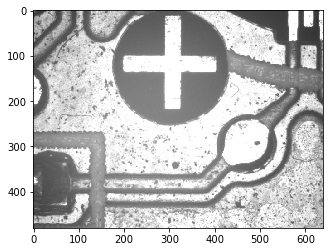

In [1]:
import cv2 as cv
from  matplotlib import pyplot as plt

imgcolor = cv.imread('./01.jpg')
img = cv.cvtColor(imgcolor, cv.COLOR_BGR2GRAY)
img = cv.resize(img,dsize=None,fx=0.093,fy=0.093,interpolation=cv.INTER_LINEAR)
print(img.shape)

plt.imshow(imgcolor[:,:,::-1])

读入模版

(20, 20)


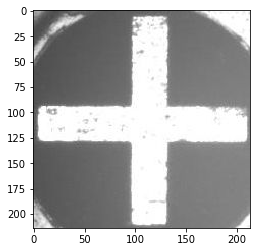

In [2]:
tmpcolor = cv.imread('./model.jpg')
tmp = cv.cvtColor(tmpcolor, cv.COLOR_BGR2GRAY)
tmp = cv.resize(tmp,dsize=None,fx=0.093,fy=0.093,interpolation=cv.INTER_LINEAR)
print(tmp.shape)

plt.imshow(tmpcolor[:,:,::-1])

## python opencv库函数模版匹配

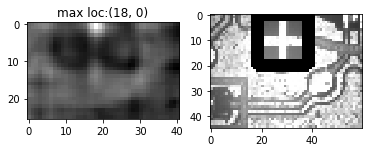

In [3]:
res = cv.matchTemplate(img, tmp, cv.TM_CCOEFF_NORMED)
min_Val, max_Val, min_Loc, max_Loc = cv.minMaxLoc(res)

plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(res, cmap=plt.cm.gray)
plt.title('max loc:{}'.format(max_Loc))

plt.subplot(1,2,2)
img_rect = cv.rectangle(img, max_Loc, (max_Loc[0]+tmp.shape[1], max_Loc[1]+tmp.shape[0]), (0, 0, 255), 3)
plt.imshow(img_rect, cmap=plt.cm.gray)

## FPGA模版匹配

### 加载Overlay

Overlay模块封装了ARM CPU与FPGA的PL部分进行交互的接口。

In [4]:
from pynq import Overlay
overlay = Overlay("./ncc.bit")
ncc = overlay.ncc_0

### 分配内存供IP使用

In [5]:
from pynq import allocate
tmp_rows = tmp.shape[0]
tmp_cols = tmp.shape[1]
img_rows = img.shape[0]
img_cols = img.shape[1]
img_buffer = allocate(shape=(img_rows*img_cols,), dtype='u1')
tmp_buffer = allocate(shape=(tmp_rows*tmp_cols,), dtype='u1')
dst_buffer = allocate(shape=((img_rows-tmp_rows+1)*(img_cols-tmp_cols+1),), dtype='u1')
img.shape,tmp.shape

((45, 60), (20, 20))

将python的本地数据，复制到我们刚分配的内存中。

In [6]:
import numpy as np
np.copyto(img_buffer, (np.uint8(img)).flatten())
np.copyto(tmp_buffer, (np.uint8(tmp)).flatten())
img_buffer.shape, tmp_buffer.shape

((2700,), (400,))

### 查看IP

In [7]:
ncc.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  temlpate_rows = Register(temlpate_rows=write-only),
  template_cols = Register(template_cols=write-only),
  img_rows = Register(img_rows=write-only),
  img_cols = Register(img_cols=write-only)
}

### 配置IP


In [8]:
ncc.register_map.img_rows = img_rows
ncc.register_map.img_cols = img_cols
ncc.register_map.temlpate_rows = tmp_rows
ncc.register_map.template_cols = tmp_cols

### 启动IP

控制信号位于0x00地址，我们可以对其进行写入与读取来控制IP启动、监听是否完成。

In [9]:
dma0 = overlay.axi_dma_0
dma1 = overlay.axi_dma_1

ncc.register_map.CTRL.AP_START = 1

In [10]:
import time

start_time = time.time()

dma0.sendchannel.transfer(img_buffer)
dma1.sendchannel.transfer(tmp_buffer)
dma0.recvchannel.transfer(dst_buffer)
dma0.sendchannel.wait() # wait for send channel
dma0.recvchannel.wait() # wait for recv channel
dma1.sendchannel.wait() # wait for send channel

end_time = time.time()

print("耗时：{}s".format((end_time - start_time)))

耗时：0.1840953826904297s


结果已经被写入到了`dst_buffer`中，我们可以进行查看

### 结果

(18, 0)


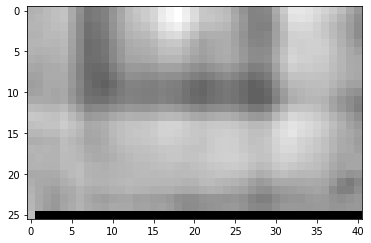

In [11]:
out_img = dst_buffer.reshape(img_rows-tmp_rows+1,img_cols-tmp_cols+1)
plt.imshow(out_img,  cmap=plt.cm.gray)
min_Val, max_Val, min_Loc, max_Loc = cv.minMaxLoc(out_img)
print(max_Loc)

查找模版位置正确

![jupyter](./CPU_time.png)
<br/>在CPU上运行程序耗时：0.63s
<br/>在FPGA上运行程序耗时：0.18s
<br/>极大地提高了运行速率